In [1]:
!wget https://raw.githubusercontent.com/luis-huacho/proyecto-segmentacion-autoetiquetado/refs/heads/master/output/openclip_avocado_labels_2.csv
!wget https://raw.githubusercontent.com/luis-huacho/proyecto-segmentacion-autoetiquetado/refs/heads/master/avocado_dataset/description.xlsx

--2025-06-30 22:59:58--  https://raw.githubusercontent.com/luis-huacho/proyecto-segmentacion-autoetiquetado/refs/heads/master/output/openclip_avocado_labels_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495940 (484K) [text/plain]
Saving to: ‘openclip_avocado_labels_2.csv’

openclip_avocado_la 100%[===================>] 484.32K  --.-KB/s    in 0.04s   

2025-06-30 22:59:58 (12.5 MB/s) - ‘openclip_avocado_labels_2.csv’ saved [495940/495940]

--2025-06-30 22:59:58--  https://raw.githubusercontent.com/luis-huacho/proyecto-segmentacion-autoetiquetado/refs/heads/master/avocado_dataset/description.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent

In [2]:
import pandas as pd
from pathlib import Path

# === 1. Rutas de entrada/salida ==============================================
DESCRIPTION_PATH = Path("description.xlsx")
PREDICTIONS_PATH = Path("openclip_avocado_labels_2.csv")
OUTPUT_PATH      = Path("avocado_comparison_results.csv")

# === 2. Cargar datasets =======================================================
desc_df = pd.read_excel(
    DESCRIPTION_PATH,
    usecols=["File Name", "Ripening Index Classification"]
)
pred_df = pd.read_csv(PREDICTIONS_PATH)

# === 3. Preparar claves de unión =============================================
# El CSV trae la extensión; la añadimos a File Name para emparejar.
desc_df["image_name"] = desc_df["File Name"].astype(str).str.strip() + ".jpg"

# Mapear índice 1-5 → etiqueta de clase
index_to_label = {1: "underripe", 2: "underripe",
                  3: "ripe",      4: "ripe",
                  5: "overripe"}
desc_df["actual_label"] = desc_df["Ripening Index Classification"].map(index_to_label)

# === 4. Fusionar y evaluar ====================================================
merged = (desc_df[["image_name", "actual_label"]]
          .merge(pred_df, on="image_name", how="inner"))

merged["correct"] = merged["actual_label"] == merged["predicted_label"]
accuracy = merged["correct"].mean()

confusion = pd.crosstab(
    merged["actual_label"],
    merged["predicted_label"],
    dropna=False
)

# === 5. Guardar resultados detallados ========================================
cols_to_save = ["image_name", "actual_label", "predicted_label", "correct"]
# Añadimos 'confidence' si existe en el CSV de predicciones
if "confidence" in merged.columns:
    cols_to_save.append("confidence")

merged[cols_to_save].to_csv(OUTPUT_PATH, index=False)

# === 6. Mostrar resumen por consola ==========================================
print(f"Imágenes evaluadas: {len(merged):,}")
print(f"Precisión global : {accuracy:.2%}\n")
print("Matriz de confusión:")
print(confusion)

Imágenes evaluadas: 14,710
Precisión global : 45.68%

Matriz de confusión:
predicted_label  overripe  ripe  underripe
actual_label                              
overripe             1586  1278          0
ripe                  968  5082          0
underripe               0  5745         51


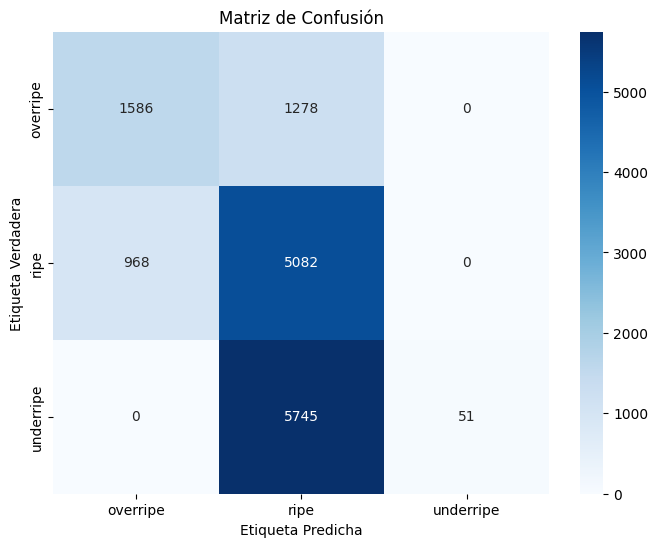


Métricas de Clasificación por Clase:
              precision    recall  f1-score   support

    overripe       0.62      0.55      0.59      2864
        ripe       0.42      0.84      0.56      6050
   underripe       1.00      0.01      0.02      5796

    accuracy                           0.46     14710
   macro avg       0.68      0.47      0.39     14710
weighted avg       0.69      0.46      0.35     14710



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# === 7. Graficar Matriz de Confusión ==========================================
# Usamos la matriz de confusión calculada previamente
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# === 8. Mostrar Métricas de Clasificación por Clase ==========================
# Usamos classification_report de scikit-learn para obtener precisión y recall por clase
print("\nMétricas de Clasificación por Clase:")
print(classification_report(merged["actual_label"], merged["predicted_label"]))
